# Issue tracker classification using RNN

### Importing required packages into python

In [1]:
# Required dependencies
# 1. NLTK
# 2. Gensim for word2vec
# 3. Keras with tensorflow/theano backend


import numpy as np
np.random.seed(1337)
import json, re, nltk, string, csv, sys, codecs
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge
from keras import layers
from keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt


/home/eruwsil/anaconda3/envs/MLpy27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### A hack to increase size due to Error: field larger than field limit (131072)

In [2]:
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt / 10)
        decrement = True

### Initializing Hyper parameter

In [3]:
#1. Word2vec parameters
min_word_frequency_word2vec = 5
embed_size_word2vec = 200
context_window_word2vec = 5

#2. Classifier hyperparameters
numCV = 10
max_sentence_len = 50
min_sentence_length = 15
rankK = 10
batch_size = 32

### Define the data files
CSV data format:

"General.Eriref";"General.Heading";"Answer.Answer";"Observation.Observation";"TR History Answer.Answered by user"

Array element[0] = "General.Eriref" (Contains only the bug number)

Array element[1] = "General.Heading" (Contains the heading)

Array element[2] = "Answer.Answer" (The unstructured natural text Answer section)--NOT USED IN THIS PROJECT

Array element[3] = "Observation.Observation" (Detailed description of the issue. Free text)

Array element[4] = "TR History Answer.Answered by user" (The developer who fixed and answered the issue ticket)

In [4]:
open_bugs_csv = 'e1_open.csv'
closed_bugs_csv = 'm15_closed.csv'

### Preprocess the open bugs, extract the vocabulary and learn the word2vec representation


In [5]:
with open(open_bugs_csv) as data_file:
    data = csv.reader(data_file, delimiter=';')

    all_data = []
    for item in data:
        #1. Remove \r 
        current_title = unicode(item[1], errors='ignore').replace('\r', ' ')
        #print current_title
        current_desc = unicode(item[3], errors='ignore').replace('\r', ' ')
        #print current_desc
        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', current_desc)    
        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]    
        #4. Remove hex code
        current_desc = re.sub(r'(\w+)0x\w+', '', current_desc)
        current_title= re.sub(r'(\w+)0x\w+', '', current_title)    
        #5. Change to lower case
        current_desc = current_desc.lower()
        current_title = current_title.lower()    
        #6. Tokenize
        current_desc_tokens = nltk.word_tokenize(current_desc)
        current_title_tokens = nltk.word_tokenize(current_title)
        #7. Strip trailing punctuation marks    
        current_desc_filter = [word.strip(string.punctuation) for word in current_desc_tokens]
        current_title_filter = [word.strip(string.punctuation) for word in current_title_tokens]      
        #8. Join the lists
        current_data = current_title_filter + current_desc_filter
        current_data = filter(None, current_data)
        all_data.append(current_data)
        
#print(len(all_data))
# Learn the word2vec model and extract vocabulary
# A vocabulary is constructed and the word2vec model is learnt using the preprocessed data. 
# The word2vec model provides a semantic word representation for every word in the vocabulary.
wordvec_model = Word2Vec(all_data, min_count=min_word_frequency_word2vec, size=embed_size_word2vec, window=context_window_word2vec)
vocabulary = wordvec_model.wv.vocab
#print vocabulary
vocab_size = len(vocabulary)

###  Preprocess the closed bugs, using the extracted the vocabulary

The closed bug trackers are used for training and testing the classifier. 

(1) The closed bugs are loaded

(2) Data(Heading and Observarion) are preprocessed



In [6]:
with open(closed_bugs_csv) as data_file:
    data = csv.reader(data_file, delimiter=';')

    all_data = []
    all_owner = []    
    for item in data:
        #1. Remove \r 
        current_title = unicode(item[1], errors='ignore').replace('\r', ' ')
        current_desc = unicode(item[3], errors='ignore').replace('\r', ' ')
        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', current_desc)
        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]
        #4. Remove hex code
        current_desc = re.sub(r'(\w+)0x\w+', '', current_desc)
        current_title= re.sub(r'(\w+)0x\w+', '', current_title)
        #5. Change to lower case
        current_desc = current_desc.lower()
        current_title = current_title.lower()
        #6. Tokenize
        current_desc_tokens = nltk.word_tokenize(current_desc)
        current_title_tokens = nltk.word_tokenize(current_title)
        #7. Strip punctuation marks
        current_desc_filter = [word.strip(string.punctuation) for word in current_desc_tokens]
        current_title_filter = [word.strip(string.punctuation) for word in current_title_tokens]       
        #8. Join the lists
        current_data = current_title_filter + current_desc_filter
        current_data = filter(None, current_data)
        all_data.append(current_data)
        all_owner.append(item[4])
#        print all_data

### Split cross validation sets and perform deep learning + softamx based classification

The ten times chronological cross validation split is performed as follows:


Starting work on cross validation set 1
Creating Model


/home/eruwsil/anaconda3/envs/MLpy27/lib/python2.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/eruwsil/anaconda3/envs/MLpy27/lib/python2.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/eruwsil/anaconda3/envs/MLpy27/lib/python2.7/site-packages/ipykernel_launcher.py:93: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/20
74/74 [==============================] - 10s 130ms/step - loss: 4.6367 - acc: 0.0541
Epoch 2/20
74/74 [==============================] - 7s 95ms/step - loss: 3.9130 - acc: 0.0676
Epoch 3/20
74/74 [==============================] - 8s 107ms/step - loss: 3.1084 - acc: 0.1622
Epoch 4/20
74/74 [==============================] - 8s 107ms/step - loss: 2.7026 - acc: 0.2432
Epoch 5/20
74/74 [==============================] - 8s 109ms/step - loss: 2.6111 - acc: 0.2297
Epoch 6/20
74/74 [==============================] - 8s 108ms/step - loss: 2.3558 - acc: 0.3378
Epoch 7/20
74/74 [==============================] - 7s 100ms/step - loss: 2.2117 - acc: 0.2838
Epoch 8/20
74/74 [==============================] - 8s 113ms/step - loss: 2.1818 - acc: 0.4324
Epoch 9/20
74/74 [==============================] - 9s 119ms/step - loss: 2.1694 - acc: 0.3919
Epoch 10/20
74/74 [==============================] - 9s 122ms/step - loss: 1.6200 - acc: 0.5541
Epoch 11/20
74/74 [==============================

/home/eruwsil/anaconda3/envs/MLpy27/lib/python2.7/site-packages/ipykernel_launcher.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


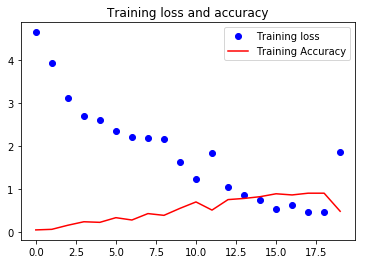

Starting work on cross validation set 2
Creating Model
Epoch 1/20
149/149 [==============================] - 15s 101ms/step - loss: 4.4454 - acc: 0.0403
Epoch 2/20
149/149 [==============================] - 14s 94ms/step - loss: 4.4161 - acc: 0.0470
Epoch 3/20
149/149 [==============================] - 14s 96ms/step - loss: 3.4694 - acc: 0.1879
Epoch 4/20
149/149 [==============================] - 14s 95ms/step - loss: 3.2583 - acc: 0.1812
Epoch 5/20
149/149 [==============================] - 12s 80ms/step - loss: 2.9866 - acc: 0.2953
Epoch 6/20
149/149 [==============================] - 12s 81ms/step - loss: 2.7092 - acc: 0.3020
Epoch 7/20
149/149 [==============================] - 13s 85ms/step - loss: 2.4486 - acc: 0.4161
Epoch 8/20
149/149 [==============================] - 14s 94ms/step - loss: 2.1733 - acc: 0.4966
Epoch 9/20
149/149 [==============================] - 13s 87ms/step - loss: 2.0339 - acc: 0.4497
Epoch 10/20
149/149 [==============================] - 15s 100ms/step -

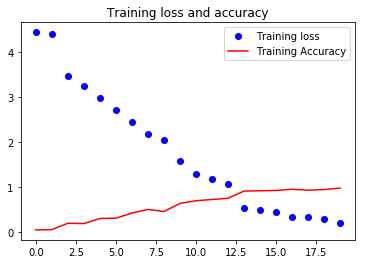

Starting work on cross validation set 3
Creating Model
Epoch 1/20
225/225 [==============================] - 20s 89ms/step - loss: 4.5157 - acc: 0.0400
Epoch 2/20
225/225 [==============================] - 17s 77ms/step - loss: 4.7816 - acc: 0.0800
Epoch 3/20
225/225 [==============================] - 18s 79ms/step - loss: 3.9029 - acc: 0.1156
Epoch 4/20
225/225 [==============================] - 19s 85ms/step - loss: 3.7572 - acc: 0.1022
Epoch 5/20
225/225 [==============================] - 17s 75ms/step - loss: 3.5465 - acc: 0.1289
Epoch 6/20
225/225 [==============================] - 18s 78ms/step - loss: 3.2795 - acc: 0.1644
Epoch 7/20
225/225 [==============================] - 18s 81ms/step - loss: 3.1670 - acc: 0.2489
Epoch 8/20
225/225 [==============================] - 18s 79ms/step - loss: 2.9801 - acc: 0.2444
Epoch 9/20
225/225 [==============================] - 18s 81ms/step - loss: 3.1724 - acc: 0.2756
Epoch 10/20
225/225 [==============================] - 17s 77ms/step - l

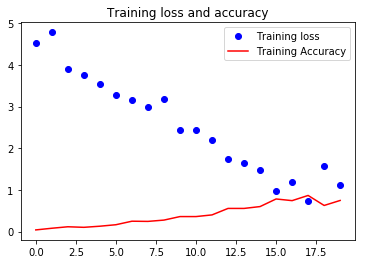

Starting work on cross validation set 4
Creating Model
Epoch 1/20
301/301 [==============================] - 24s 80ms/step - loss: 4.8524 - acc: 0.0365
Epoch 2/20
301/301 [==============================] - 20s 68ms/step - loss: 4.1264 - acc: 0.0864
Epoch 3/20
301/301 [==============================] - 21s 70ms/step - loss: 3.8839 - acc: 0.0731
Epoch 4/20
301/301 [==============================] - 20s 67ms/step - loss: 3.5926 - acc: 0.1395
Epoch 5/20
301/301 [==============================] - 22s 72ms/step - loss: 3.5098 - acc: 0.2027
Epoch 6/20
301/301 [==============================] - 22s 75ms/step - loss: 3.1414 - acc: 0.2425
Epoch 7/20
301/301 [==============================] - 21s 70ms/step - loss: 2.8183 - acc: 0.2890
Epoch 8/20
301/301 [==============================] - 20s 68ms/step - loss: 2.3671 - acc: 0.4053
Epoch 9/20
301/301 [==============================] - 24s 80ms/step - loss: 2.1544 - acc: 0.4518
Epoch 10/20
301/301 [==============================] - 24s 79ms/step - l

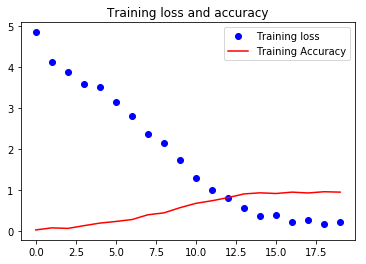

Starting work on cross validation set 5
Creating Model
Epoch 1/20
376/376 [==============================] - 30s 80ms/step - loss: 4.7502 - acc: 0.0372
Epoch 2/20
376/376 [==============================] - 26s 69ms/step - loss: 4.2348 - acc: 0.0612
Epoch 3/20
376/376 [==============================] - 27s 71ms/step - loss: 4.0079 - acc: 0.0824
Epoch 4/20
376/376 [==============================] - 26s 68ms/step - loss: 3.7133 - acc: 0.1117
Epoch 5/20
376/376 [==============================] - 28s 73ms/step - loss: 3.4057 - acc: 0.1809
Epoch 6/20
376/376 [==============================] - 27s 72ms/step - loss: 3.1145 - acc: 0.2101
Epoch 7/20
376/376 [==============================] - 26s 68ms/step - loss: 2.8491 - acc: 0.3165
Epoch 8/20
376/376 [==============================] - 27s 71ms/step - loss: 2.4942 - acc: 0.3697
Epoch 9/20
376/376 [==============================] - 27s 72ms/step - loss: 2.0101 - acc: 0.4867
Epoch 10/20
376/376 [==============================] - 26s 70ms/step - l

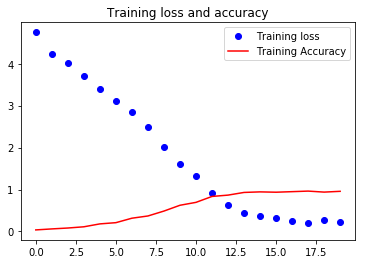

Starting work on cross validation set 6
Creating Model
Epoch 1/20
452/452 [==============================] - 32s 71ms/step - loss: 4.7349 - acc: 0.0310
Epoch 2/20
452/452 [==============================] - 37s 82ms/step - loss: 4.1802 - acc: 0.1018
Epoch 3/20
452/452 [==============================] - 38s 84ms/step - loss: 3.9415 - acc: 0.1018
Epoch 4/20
452/452 [==============================] - 33s 74ms/step - loss: 3.7645 - acc: 0.1261
Epoch 5/20
452/452 [==============================] - 33s 73ms/step - loss: 3.4011 - acc: 0.1770
Epoch 6/20
452/452 [==============================] - 36s 79ms/step - loss: 3.1756 - acc: 0.2301
Epoch 7/20
452/452 [==============================] - 34s 75ms/step - loss: 2.9732 - acc: 0.2810
Epoch 8/20
452/452 [==============================] - 33s 73ms/step - loss: 2.5793 - acc: 0.3385
Epoch 9/20
452/452 [==============================] - 33s 74ms/step - loss: 2.2497 - acc: 0.4159
Epoch 10/20
452/452 [==============================] - 32s 70ms/step - l

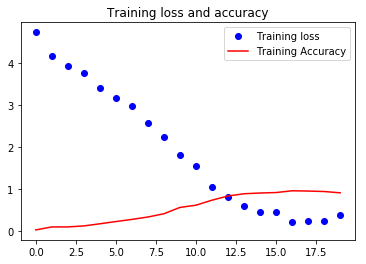

Starting work on cross validation set 7
Creating Model
Epoch 1/20
528/528 [==============================] - 38s 72ms/step - loss: 4.6296 - acc: 0.0511
Epoch 2/20
528/528 [==============================] - 34s 64ms/step - loss: 4.1529 - acc: 0.0833
Epoch 3/20
528/528 [==============================] - 35s 66ms/step - loss: 3.9034 - acc: 0.1004
Epoch 4/20
528/528 [==============================] - 40s 75ms/step - loss: 3.6703 - acc: 0.1420
Epoch 5/20
528/528 [==============================] - 36s 67ms/step - loss: 3.4374 - acc: 0.1780
Epoch 6/20
528/528 [==============================] - 36s 69ms/step - loss: 3.1857 - acc: 0.2216
Epoch 7/20
528/528 [==============================] - 36s 69ms/step - loss: 2.8405 - acc: 0.2898
Epoch 8/20
528/528 [==============================] - 33s 63ms/step - loss: 2.5054 - acc: 0.3390
Epoch 9/20
528/528 [==============================] - 33s 62ms/step - loss: 2.0530 - acc: 0.4773
Epoch 10/20
528/528 [==============================] - 35s 66ms/step - l

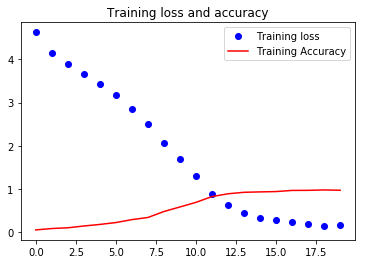

Starting work on cross validation set 8
Creating Model
Epoch 1/20
603/603 [==============================] - 43s 71ms/step - loss: 4.6045 - acc: 0.0448
Epoch 2/20
603/603 [==============================] - 40s 66ms/step - loss: 4.1237 - acc: 0.0697
Epoch 3/20
603/603 [==============================] - 42s 70ms/step - loss: 3.9144 - acc: 0.0879
Epoch 4/20
603/603 [==============================] - 42s 69ms/step - loss: 3.7059 - acc: 0.1343
Epoch 5/20
603/603 [==============================] - 41s 68ms/step - loss: 3.4883 - acc: 0.1675
Epoch 6/20
603/603 [==============================] - 43s 71ms/step - loss: 3.2081 - acc: 0.2338
Epoch 7/20
603/603 [==============================] - 43s 71ms/step - loss: 2.8525 - acc: 0.2819
Epoch 8/20
603/603 [==============================] - 41s 69ms/step - loss: 2.5183 - acc: 0.3665
Epoch 9/20
603/603 [==============================] - 45s 74ms/step - loss: 2.0650 - acc: 0.4643
Epoch 10/20
603/603 [==============================] - 42s 70ms/step - l

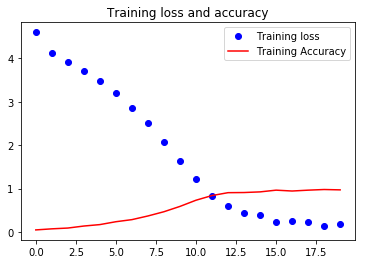

Starting work on cross validation set 9
Creating Model
Epoch 1/20
679/679 [==============================] - 52s 76ms/step - loss: 4.5677 - acc: 0.0353
Epoch 2/20
679/679 [==============================] - 44s 65ms/step - loss: 4.0835 - acc: 0.0751
Epoch 3/20
679/679 [==============================] - 49s 72ms/step - loss: 3.8820 - acc: 0.1119
Epoch 4/20
679/679 [==============================] - 47s 69ms/step - loss: 3.6481 - acc: 0.1517
Epoch 5/20
679/679 [==============================] - 48s 70ms/step - loss: 3.4386 - acc: 0.1767
Epoch 6/20
679/679 [==============================] - 48s 71ms/step - loss: 3.1435 - acc: 0.2209
Epoch 7/20
679/679 [==============================] - 46s 68ms/step - loss: 2.8589 - acc: 0.2784
Epoch 8/20
679/679 [==============================] - 51s 75ms/step - loss: 2.4877 - acc: 0.3638
Epoch 9/20
679/679 [==============================] - 46s 68ms/step - loss: 2.1346 - acc: 0.4639
Epoch 10/20
679/679 [==============================] - 47s 70ms/step - l

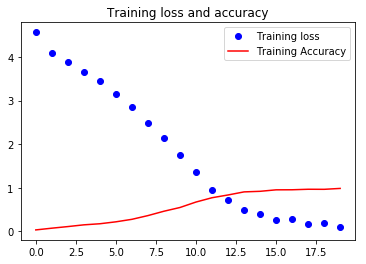

Starting work on cross validation set 10
Creating Model
Epoch 1/20
755/755 [==============================] - 49s 65ms/step - loss: 4.5609 - acc: 0.0503
Epoch 2/20
755/755 [==============================] - 52s 68ms/step - loss: 4.0584 - acc: 0.0861
Epoch 3/20
755/755 [==============================] - 53s 71ms/step - loss: 3.8712 - acc: 0.1046
Epoch 4/20
755/755 [==============================] - 51s 68ms/step - loss: 3.6618 - acc: 0.1391
Epoch 5/20
755/755 [==============================] - 57s 76ms/step - loss: 3.4205 - acc: 0.1642
Epoch 6/20
755/755 [==============================] - 57s 76ms/step - loss: 3.0951 - acc: 0.2305
Epoch 7/20
755/755 [==============================] - 54s 72ms/step - loss: 2.7594 - acc: 0.2967
Epoch 8/20
755/755 [==============================] - 51s 68ms/step - loss: 2.4296 - acc: 0.3748
Epoch 9/20
755/755 [==============================] - 52s 69ms/step - loss: 1.9622 - acc: 0.4940
Epoch 10/20
755/755 [==============================] - 49s 65ms/step - 

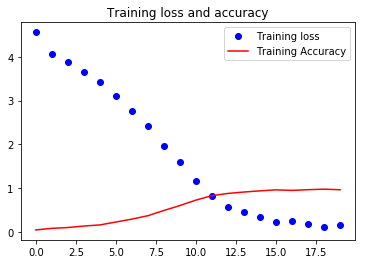

In [7]:
totalLength = len(all_data)
splitLength = int(totalLength / (numCV + 1))

for i in range(1, numCV + 1):
    # Split cross validation set
    print("Starting work on cross validation set {0}".format(i))
    train_data = all_data[:i*splitLength-1]
    test_data = all_data[i*splitLength:(i+1)*splitLength-1]
    train_owner = all_owner[:i*splitLength-1]
    test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]
    
    # Remove words outside the vocabulary
    updated_train_data = []    
    updated_train_data_length = []    
    updated_train_owner = []
    final_test_data = []
    final_test_owner = []
    for j, item in enumerate(train_data):
        current_train_filter = [word for word in item if word in vocabulary]
        if len(current_train_filter) >= min_sentence_length:  
          updated_train_data.append(current_train_filter)
          updated_train_owner.append(train_owner[j])  
          
    for j, item in enumerate(test_data):
        current_test_filter = [word for word in item if word in vocabulary]  
        if len(current_test_filter) >= min_sentence_length:
          final_test_data.append(current_test_filter)          
          final_test_owner.append(test_owner[j])          
    
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_test_data = []
    updated_test_owner = []
    updated_test_data_length = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])

    unique_train_label = list(set(updated_train_owner))
    classes = np.array(unique_train_label)
    
    # Create train and test data for deep learning + softmax
    X_train = np.empty(shape=[len(updated_train_data), max_sentence_len, embed_size_word2vec], dtype='float32')
    Y_train = np.empty(shape=[len(updated_train_owner), 1], dtype='int32')
    # 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
    for j, curr_row in enumerate(updated_train_data):
        sequence_cnt = 0         
        for item in curr_row:
            if item in vocabulary:
                X_train[j, sequence_cnt, :] = wordvec_model[item] 
                sequence_cnt = sequence_cnt + 1                
                if sequence_cnt == max_sentence_len-1:
                          break                
        for k in range(sequence_cnt, max_sentence_len):
            X_train[j, k, :] = np.zeros((1, embed_size_word2vec))        
        Y_train[j, 0] = unique_train_label.index(updated_train_owner[j])
    
    X_test = np.empty(shape=[len(updated_test_data), max_sentence_len, embed_size_word2vec], dtype='float32')
    Y_test = np.empty(shape=[len(updated_test_owner),1], dtype='int32')
    # 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
    for j, curr_row in enumerate(updated_test_data):
        sequence_cnt = 0          
        for item in curr_row:
            if item in vocabulary:
                X_test[j, sequence_cnt, :] = wordvec_model[item] 
                sequence_cnt = sequence_cnt + 1                
                if sequence_cnt == max_sentence_len-1:
                          break                
        for k in range(sequence_cnt, max_sentence_len):
            X_test[j, k, :] = np.zeros((1, embed_size_word2vec))        
        Y_test[j, 0] = unique_train_label.index(updated_test_owner[j])
        
    y_train = np_utils.to_categorical(Y_train, len(unique_train_label))
    y_test = np_utils.to_categorical(Y_test, len(unique_train_label))


    # TODO: Add x_train and x_test
    
    # Construct the deep learning model
    print("Creating Model")
    sequence = Input(shape=(max_sentence_len, embed_size_word2vec), dtype='float32')
    forwards_1 = LSTM(1024)(sequence)
    after_dp_forward_4 = Dropout(0.20)(forwards_1) 
    backwards_1 = LSTM(1024, go_backwards=True)(sequence)
    after_dp_backward_4 = Dropout(0.20)(backwards_1)         
    #merged = merge([after_dp_forward_4, after_dp_backward_4], mode='concat', concat_axis=-1)
    merged = layers.concatenate([after_dp_forward_4, after_dp_backward_4], axis=-1)
    after_dp = Dropout(0.5)(merged)
    output = Dense(len(unique_train_label), activation='softmax')(after_dp)                
    model = Model(input=sequence, output=output)            
    rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])    
    hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=20)  # Rename nb_epochs to epochs // Value original: 200
    
    predict = model.predict(X_test)        
    accuracy = []
    sortedIndices = []
    pred_classes = []
    if len(predict) == 0:
        exit(1)  # Avoid divide by zero
    for ll in predict:
          sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
    for k in range(1, rankK + 1):
          id = 0
          trueNum = 0
          for sortedInd in sortedIndices:
            pred_classes.append(classes[sortedInd[:k]])
            if y_test[id] in classes[sortedInd[:k]]:
                  trueNum += 1            
            id += 1
          accuracy.append((float(trueNum) / len(predict)) * 100)
    print("Test accuracy: ", accuracy)       
    
    train_result = hist.history        
    print(train_result)
    
    # Loss curves for validation and training
    test_loss = hist.history['loss']
    test_accuracy = hist.history['acc']
    #val_loss = hist.history['val_loss']

    epochs = range(len(test_loss))

    plt.figure()

    plt.plot(epochs, test_loss, 'bo', label='Training loss')
    plt.plot(epochs, test_accuracy, 'r', label='Training Accuracy')
    plt.title('Training loss and accuracy')
    plt.legend()

    plt.show()
    
    del model

### Split cross validation sets and perform baseline classifiers

In [9]:
totalLength = len(all_data)
splitLength = totalLength / (numCV + 1)

for i in range(1, numCV+1):
    # Split cross validation set
    print("Starting cross validation {0}".format(i))
    train_data = all_data[:i*splitLength-1]
    test_data = all_data[i*splitLength:(i+1)*splitLength-1]
    train_owner = all_owner[:i*splitLength-1]
    test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]
    
    # Remove words outside the vocabulary
    updated_train_data = []    
    updated_train_data_length = []    
    updated_train_owner = []
    final_test_data = []
    final_test_owner = []
    for j, item in enumerate(train_data):
        current_train_filter = [word for word in item if word in vocabulary]
        if len(current_train_filter)>=min_sentence_length:  
          updated_train_data.append(current_train_filter)
          updated_train_owner.append(train_owner[j])  
          
    for j, item in enumerate(test_data):
        current_test_filter = [word for word in item if word in vocabulary]  
        if len(current_test_filter)>=min_sentence_length:
          final_test_data.append(current_test_filter)          
          final_test_owner.append(test_owner[j])          
    
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_test_data = []
    updated_test_owner = []
    updated_test_data_length = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])  
    
    train_data = []
    for item in updated_train_data:
          train_data.append(' '.join(item))
         
    test_data = []
    for item in updated_test_data:
          test_data.append(' '.join(item))
    
    vocab_data = []
    for item in vocabulary:
          vocab_data.append(item)
    
    # Extract tf based bag of words representation
    tfidf_transformer = TfidfTransformer(use_idf=False)
    count_vect = CountVectorizer(min_df=1, vocabulary= vocab_data,dtype=np.int32)
    
    train_counts = count_vect.fit_transform(train_data)       
    train_feats = tfidf_transformer.fit_transform(train_counts)
    print(train_feats.shape)
    
    test_counts = count_vect.transform(test_data)
    test_feats = tfidf_transformer.transform(test_counts)
    print(test_feats.shape)
    print("=" * 20)
    
    
    
    # perform classifification
    for classifier in range(1,5):
        #classifier = 3 # 1 - Niave Bayes, 2 - Softmax, 3 - cosine distance, 4 - SVM
        print classifier 
        if classifier == 1:            
            classifierModel = MultinomialNB(alpha=0.01)        
            classifierModel = OneVsRestClassifier(classifierModel).fit(train_feats, updated_train_owner)
            predict = classifierModel.predict_proba(test_feats)  
            classes = classifierModel.classes_  
            
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if updated_test_owner[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print accuracy                                    
        elif classifier == 2:            
            classifierModel = LogisticRegression(solver='lbfgs', penalty='l2', tol=0.01)
            classifierModel = OneVsRestClassifier(classifierModel).fit(train_feats, updated_train_owner)
            predict = classifierModel.predict(test_feats)
            classes = classifierModel.classes_ 
            
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if updated_test_owner[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print accuracy                                   
        elif classifier == 3:            
            predict = cosine_similarity(test_feats, train_feats)
            classes = np.array(updated_train_owner)
            classifierModel = []
            
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if updated_test_owner[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print accuracy                        
        elif classifier == 4:            
            classifierModel = svm.SVC(probability=True, verbose=False, decision_function_shape='ovr', random_state=42)
            classifierModel.fit(train_feats, updated_train_owner)
            predict = classifierModel.predict(test_feats)
            classes = classifierModel.classes_ 
        
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if updated_test_owner[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print accuracy                            
    

Starting cross validation 1
(74, 7924)
(31, 7924)
1
[22.58064516129032, 29.03225806451613, 32.25806451612903, 35.483870967741936, 38.70967741935484, 45.16129032258064, 45.16129032258064, 45.16129032258064, 45.16129032258064, 48.38709677419355]
2
[9.67741935483871, 9.67741935483871, 9.67741935483871, 9.67741935483871, 9.67741935483871, 16.129032258064516, 16.129032258064516, 16.129032258064516, 16.129032258064516, 16.129032258064516]
3
[3.225806451612903, 16.129032258064516, 25.806451612903224, 29.03225806451613, 29.03225806451613, 32.25806451612903, 35.483870967741936, 38.70967741935484, 41.935483870967744, 48.38709677419355]
4
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Starting cross validation 2
(149, 7924)
(54, 7924)
1
[9.25925925925926, 12.962962962962962, 24.074074074074073, 27.77777777777778, 31.48148148148148, 37.03703703703704, 38.88888888888889, 40.74074074074074, 42.592592592592595, 42.592592592592595]
2
[0.0, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5

##  issues and Remedies

#### Issue: # Hack to increase size due to Error: field larger than field limit (131072)

#### Remedy:

```python
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt / 10)
        decrement = True
```

#### Issue: 

```python
AttributeError                            Traceback (most recent call last)
<ipython-input-4-a44dbf7d73b5> in <module>()
     34 # Learn the word2vec model and extract vocabulary
     35 wordvec_model = Word2Vec(all_data, min_count=min_word_frequency_word2vec, size=embed_size_word2vec, window=context_window_word2vec)
---> 36 vocabulary = wordvec_model.vocab
     37 vocab_size = len(vocabulary)

AttributeError: 'Word2Vec' object has no attribute 'vocab'
```

#### Remedy:

vocabulary = wordvec_model.wv.vocab


#### Issue: 

```python
TypeError                                 Traceback (most recent call last)
<ipython-input-2-665fcb716c54> in <module>()
    225     backwards_1 = LSTM(1024, go_backwards=True)(sequence)
    226     after_dp_backward_4 = Dropout(0.20)(backwards_1)
--> 227     merged = merge([after_dp_forward_4, after_dp_backward_4], mode='concat', concat_axis=-1)
    228     after_dp = Dropout(0.5)(merged)
    229     output = Dense(len(unique_train_label), activation='softmax')(after_dp)

TypeError: 'module' object is not callable
```
#### Remedy:
```python
merged = layers.concatenate([after_dp_forward_4, after_dp_backward_4], axis=-1)

```
```python
---------------------------------------------------------------------------
ImportError                               Traceback (most recent call last)
<ipython-input-1-56f416da9cda> in <module>()
     12 from keras.preprocessing import sequence
     13 from keras.models import Model
---> 14 from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Merge
     15 from keras.optimizers import RMSprop
     16 from keras.utils import np_utils

ImportError: cannot import name Merge
```
